In [1]:
import pymongo
import re
from bs4 import BeautifulSoup
import langid
from langid.langid import LanguageIdentifier, model
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import dask.dataframe as dd
from math import log, sqrt

# Task 0 - Data Cleaning and Cleansing

Cleaning the tweets is necessary prior to processing because raw tweets data often contain noise and irrelevant information, which can affect the quality of the analysis. For instance:
 1. Tweets often contain **retweets (RT), #hashtags, @mentions, emojis, URLs, and stop words** which can interfere with natural language processing tasks.
 2. Words like **"Hello"** and **"hello"** can be considered as two separate words when they are in fact the same, which is why it can also interfere with natural language processing tasks.
 
By cleaning the tweets, we can improve the accuracy and quality of the analysis which can lead to more meaningful insights.

In [2]:
# Setting up the connection to MongoDB
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client['Assignment_1'] # Database name
col = db['10000 tweets'] # Collection name

# Setting up the query
results = col.find({}).limit(5)

# Checking the tweets
for res in results:
    print(res['body']) # This will get the result from the 'body' field where the tweet is located
    print('-----------------------------------------------------')

Register for #Convergence2016 to hear@ChelleMelbourne talk about how to manage change through digital transformation https://t.co/7pxwwDeaXm
-----------------------------------------------------
CONGRATULATIONS Suzie Walker on both your beautiful little man and your FANTASTIC commitment and hard work. You... https://t.co/m4QLVq0BTr
-----------------------------------------------------
Join us @ the Hilton Sydney 2 learn how 2 make analytics pervasive across yr organisation https://t.co/xGO7cZy9yU https://t.co/otxAeyMHMV
-----------------------------------------------------
Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67pct, Winds NNW @ 0.0 km/h, Rain Today  0 mm, 1014.3 hpa &amp; Steady. #vicweather
-----------------------------------------------------
So much to see and do when you Visit Central Australia
"We have our own kind of beaches in the #RedCentreNT! The... https://t.co/eRyP7eTk9X
-----------------------------------------------------


As can be observed above, there are noticeable noises such as the URLs, Retweets, Hashtags, mentions, as well as tweets in other languages. Thus, we will be creating a function to clean the tweets and a function to remove stop words.

In [3]:
# Setting up the language identifier outside of the function to make the function more efficient
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

# Defining a function to clean tweets
def tweet_cleaner(tweet):
    # Removing URLs from tweets
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    tweet = re.sub(r'htt...', '', tweet)
    
    # Removing the retweets, e.g., "RT @Tha5SOSFamily: 650 RTS!" will become "650 RTS!"
    tweet = re.sub(r'^RT\s+@\w+:\s+', '', tweet)
    
    # Removing non-English tweets as our analysis will be focused on the English language
    lang, conf = identifier.classify(tweet)
    if lang == 'en' and conf > 0.5:
    
        # Removing the hashtags and mentions
        tweet = re.sub(r'#[^\s]+', '', tweet)    
        tweet = re.sub(r'@[^\s]+', '', tweet)

        # Converting HTML tags and entities, e.g., "&amp;" to "&"
        soup = BeautifulSoup(tweet, 'html.parser')
        for script in soup(['script', 'style']):
            script.decompose()
        tweet = soup.get_text()

        # Removing ellipsis
        tweet = re.sub(r'\.{3}', ' ', tweet)
        
        # Removing numbers as we will be focusing on words
        tweet = re.sub(r'\d+', ' ', tweet)
        
        # Removing words with repetitive letters, e.g., "aaaaaand"
        tweet = re.sub(r'\b\w*(\w)\1{2,}\w*\b', ' ', tweet)
        
        # Removing all non-ASCII characters, i.e., non-english characters
        tweet = re.sub(r'[^\u0000-\u007F]+', ' ', tweet)

        # Converting it into lowercase and removing excess whitespace
        cleaned_tweet = ' '.join(tweet.split())
    
    else:
        return ''
    
    return cleaned_tweet

Now we will be defining a function to remove the stop words. The function below will remove stop words such as, "been", "because", "until", and more, as well as removing the punctuations. In addition, we have added the "removal_list" because after further checking of the data, there are more words that should be removed such as slang words.

In [4]:
# Creating a list of words to be removed
removal_list = ['hahahaha', 'hahaha', 'haha', 'ahaha', 'hahah', 'hehe', 'huhuhu', 'wkwk', 'wkwkwk', # laughters
                'lmao', 'asap', 'bout', 'bros', 'fwiw', 'iirc', 'imho', 'icymi', # slang words
                'didnt', 'havent', 'dont', 'could', 'wouldnt', 'wont'] # was not removed properly 

# Creating a list of stop words to be removed
stop_words = set(stopwords.words('english')) 

# Defining a function to remove the stop words
def stop_words_remover(tweet):
    
    # Tokenizing the tweets into separate words
    words = word_tokenize(tweet)
    
    # Filtering the tweets word by word and removing the stop words and internet slang
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() not in removal_list]
    filtered_words = ' '.join(filtered_words)
    
    # Removing non-word and non-space characters, i.e. removing punctuations.
    filtered_words = re.sub(r'[^\w\s]', ' ', filtered_words)
    
    # Removing words that are less than 3 characters as we won't get any information from them
    filtered_words = re.sub(r'\b\w{1,3}\b', '', filtered_words)

    # Removing words that are more than 16 characters as it's probably not a word
    filtered_words = re.sub(r'\b\w{16,}\b', '', filtered_words)
    
    # Removing any remaining extra white spaces
    filtered_words = ' '.join(filtered_words.split())
    
    return filtered_words

Checking the tweets after being cleaned.

In [5]:
# Setting up the query
results = col.find({}).limit(5)

# Checking the tweets
for res in results:
    print(stop_words_remover(tweet_cleaner(res["body"])))
    print('-----------------------------------------------------')

Register hear talk manage change digital transformation
-----------------------------------------------------
CONGRATULATIONS Suzie Walker beautiful little FANTASTIC commitment hard work
-----------------------------------------------------
Join Hilton Sydney learn make analytics pervasive across organisation
-----------------------------------------------------
Wantirna Temp Winds Rain Today Steady
-----------------------------------------------------
much Visit Central Australia kind beaches
-----------------------------------------------------


C:\Users\march\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


**As can be observed, the tweets are cleaner and can be used for further analysis.**

# Task 1

## 1. Extracting Keywords

For the first part of the task, we are asked to extract the keywords from each tweet and update each original document in the MongoDB database with the new key-value pairs. The following steps will be taken:  

 1. Defining a new function called `word_stemmer` to get the root of the word by utilising one of the algorithms from `NLTK` package, `SnowballStemmer`.
 2. Defining a new function called `keywords_extractor` to extract the keywords and get their POS (Part of Speech) tag utilising the `tweet_cleaner`, `stop_words_removal`, and `pos_tag` function from the `NLTK` package.
 3. Defining a new function called `csv_converter` to convert the keywords and POS tag pair to a CSV format.
 
Please note, we won't be stemming the words as it will affect the accuracy of the part of speech tagging.

### Step 1: Defining the `word_stemmer` function

We will be using `SnowballStemmer` because it is an improved version of `PorterStemmer` (i.e., it has better accuracy and increased efficiency).

In [6]:
# Defining a function to extract the named entities from each tweet
def word_stemmer(words):
    stemmer = SnowballStemmer('english')
    
    # Setting up the list
    result = []
    for w in words:
        result.append(stemmer.stem(w))
    return result

In [7]:
# Checking if it works
word_stemmer(['Jumping', 'Killing'])

['jump', 'kill']

### Step 2: Defining the `keywords_extractor` function

The function below can be described as,

 1. Combining the `tweet_cleaner` function and `stop_words_remover` function.
 2. Tokenizing the result which will get tokens (or individual words) out of each tweet and converted into a lower case word, e.g., "Hello, World!" will become a list \["hello", "world"\].
 3. Getting the POS tag of each token.
 4. Returning a list of keyword and POS tag pairs. E.g., \["hello", "world"\] will become \[('hello', 'NN'), ('world', 'NN')\], where NN is an abbreviation for Noun singular or mass used by the `nltk.pos_tag` function. A more comprehensive list can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

In [8]:
# Defining a function to extract the keywords from each tweet
def keywords_extractor(tweet):
    words = tweet_cleaner(tweet)
    words = stop_words_remover(words)
    words = word_tokenize(words.lower())
    keywords = nltk.pos_tag(words)
    return keywords

Checking the extracted keywords to ensure that the function works.

In [9]:
# Setting up the query
results = col.find({}).limit(5)

# Checking the tweets
for res in results:
    print(keywords_extractor(res["body"]))
    print('-----------------------------------------------------')

[('register', 'NN'), ('hear', 'JJ'), ('talk', 'NN'), ('manage', 'NN'), ('change', 'NN'), ('digital', 'JJ'), ('transformation', 'NN')]
-----------------------------------------------------
[('congratulations', 'NNS'), ('suzie', 'VBP'), ('walker', 'NN'), ('beautiful', 'JJ'), ('little', 'JJ'), ('fantastic', 'JJ'), ('commitment', 'NN'), ('hard', 'JJ'), ('work', 'NN')]
-----------------------------------------------------
[('join', 'NN'), ('hilton', 'NN'), ('sydney', 'NN'), ('learn', 'VBP'), ('make', 'VBP'), ('analytics', 'NNS'), ('pervasive', 'JJ'), ('across', 'IN'), ('organisation', 'NN')]
-----------------------------------------------------
[('wantirna', 'NN'), ('temp', 'NN'), ('winds', 'VBZ'), ('rain', 'VBP'), ('today', 'NN'), ('steady', 'JJ')]
-----------------------------------------------------
[('much', 'JJ'), ('visit', 'IN'), ('central', 'JJ'), ('australia', 'NNS'), ('kind', 'NN'), ('beaches', 'NNS')]
-----------------------------------------------------


### Step 3: Defining the `csv_converter` function

After we have receive a list of keyword and POS pairs from all the tweets, we will convert them to CSV format. For example for this part of the task,  
\[('hello', 'NN'), ('world', 'NN')\] will become 'hello,NN\nworld,NN\n'.  

However, this function can be used for the other part of the task as well.

In [10]:
# Defining a function to convert key-value pairs into csv format
def csv_converter(pairs):
    csv = ""
    for pair in pairs:
        csv = csv + pair[0] + "," + pair[1] + "\n"
    return csv

## 2. Extracting Named Entities

For the second part of the task, we are asked to extract the named entities from each tweet and update each original document in the MongoDB database with the new key-value pairs. We will be defining a new function called `named_entities_extractor` to extract the named entities. We will be using `SpaCy`, which is a popular Python package for NER (Named Entity Recognition).

Please note that there are many packages for NER, such as `NLTK`. However, we will be using `SpaCy` as it is built on deep learning techniques which is more effective for identifying local patterns, features, and context in the tweets. On the other hand, NER in `NLTK` is primarily based on rule-based systems which can be more brittle and less effective at handling variations in the tweets.

### Defining the `named_entities_extractor` functions

In [11]:
# Loading the pre-trained English NER model from SpaCy
nlp = spacy.load('en_core_web_sm') 

# Defining a function to extract the named entities from each tweet
    # Please note that we will not be converting the tweet into a lower case and not removing the stop words
    # as it could reduce the accuracy of the NER model.
def named_entities_extractor(tweet):
    
    # Cleaning the tweet
    tweet = tweet_cleaner(tweet)

    # Processing the tweet using the the loaded NLP model
    # This will automatically tokenize the tweet
    tweet = nlp(tweet)
    
    # Setting up the list
    result = []
    
    # This will loop for each word in the tuple, and if its label is not a person, organisation, or location
    # it will not be added to the list
    for ent in tweet.ents:
        if ent.label_ in ['PERSON', 'ORG', 'LOC']:
            result.append((ent.text, ent.label_))
            
    return result

Checking the extracted Named Entities using the SpaCy function.

In [12]:
# Setting up the query
results = col.find({}).limit(5)

# Checking the tweets
for res in results:
    print(named_entities_extractor(res["body"]))
    print('-----------------------------------------------------')

[]
-----------------------------------------------------
[('CONGRATULATIONS Suzie Walker', 'ORG'), ('FANTASTIC', 'ORG')]
-----------------------------------------------------
[('Hilton Sydney', 'PERSON')]
-----------------------------------------------------
[('VIC', 'ORG'), ('RH', 'PERSON'), ('NNW', 'ORG'), ('km', 'PERSON'), ('hpa & Steady', 'ORG')]
-----------------------------------------------------
[]
-----------------------------------------------------


It can be observed that not all of the named entities extracted are not that accurate, but it could help with any further analysis that will be performed.

## 3. Extracting Topic

For the third part of the task, we are asked to extract the topic from each tweet and update each original document in the MongoDB database with the new key-value pairs. We will be defining a new function called `topics_extractor` to extract the topics and get their respective score as a key-value pair.
 
For the `topics_extractor` function, we will be using the `Gensim` package which is used for natural language processing and topic modelling. One of the most popular algorithms provided by `Gensim` is the LDA (Latent Dirichlet Allocation) model which is a generative statistical model for identifying the underlying topics in a corpus of documents. The goal of LDA is to discover the latent topics that are most likely to generate the observed words in a document, or in our case in a tweet.  

### Defining the `topics_extractors` function

The LDA algorithm works as follows:
 1. A fixed number of topics (K) are chosen as the input to the model.
 2. Each document/tweet is represented as a probability distribution over the topics, where the probability of each topic indicates the degree to which that topic is present in the document.
 3. Each topic is represented as a probability distribution over the words in the corpus, where the probability of each word indicates the degree to which that word is associated with the topic.
 4. The algorithm iteratively updates the probability distributions until it converges to a stable solution that maximises the likelihood of the observed data.
 
However, since we will be extracting a topic from each tweet rather than from the collection of tweets itself, we will not be combining the tweets into one dictionary.

The two main inputs of LDA model is **dictionary** and **corpus**. Where in the context of LDA,
 1. **dictionary** will map every word into unique IDs 
 2. **corpus** will consist of a list of word ID and its frequency

In [13]:
# Defining a function to extract the topics from each tweet
def topics_extractor(tweet):
    
    # Cleaning the tweets
    tweet = stop_words_remover(tweet_cleaner(tweet))
    
    # Tokenizing the tweet
    words = word_tokenize(tweet.lower())
    
    # Filtering empty tweets after being cleaned
    if not words:
        return []
    
    # Creating a dictionary and a corpus of the tokenized tweet
    dictionary = corpora.Dictionary([words])
    corpus = [dictionary.doc2bow(word) for word in [words]]

    # Setting up the LDA model
    # num_topics = 1 means that we are only looking for one topic for each tweet
    lda_model = models.LdaModel(corpus = corpus, id2word = dictionary, num_topics = 1)

    # Saving the topics
    # Since we set num_topics = 1, topicid = 0 is the only possible index, i.e., the first topic.
    # topn = 10 means we are searching for the top 10 possible topic in the tweet
    # This will yield an index and the score
    topics = lda_model.get_topic_terms(topicid = 0, topn = 10)
    
    # Setting up the list
    result = []
    for w, p in topics:
        result.append((dictionary[w], f'{p:.4%}'))
        
    return result

Checking the extracted topics and its probability.

In [14]:
# Setting up the query
results = col.find({}).limit(5)

# Checking the tweets
for res in results:
    print(topics_extractor(res["body"]))
    print('-----------------------------------------------------')

[('digital', '14.2857%'), ('manage', '14.2857%'), ('hear', '14.2857%'), ('register', '14.2857%'), ('talk', '14.2857%'), ('transformation', '14.2857%'), ('change', '14.2857%')]
-----------------------------------------------------
[('fantastic', '11.1111%'), ('work', '11.1111%'), ('little', '11.1111%'), ('walker', '11.1111%'), ('beautiful', '11.1111%'), ('congratulations', '11.1111%'), ('hard', '11.1111%'), ('suzie', '11.1111%'), ('commitment', '11.1111%')]
-----------------------------------------------------
[('learn', '11.1111%'), ('across', '11.1111%'), ('hilton', '11.1111%'), ('make', '11.1111%'), ('pervasive', '11.1111%'), ('analytics', '11.1111%'), ('sydney', '11.1111%'), ('join', '11.1111%'), ('organisation', '11.1111%')]
-----------------------------------------------------
[('today', '16.6667%'), ('wantirna', '16.6667%'), ('winds', '16.6667%'), ('rain', '16.6667%'), ('steady', '16.6667%'), ('temp', '16.6667%')]
-----------------------------------------------------
[('much', '1

From the result above, it can be observed that a word will have a higher probability of becoming a topic if its frequency is higher. Otherwise, if all words have the same frequency, the probability will be equal to $\frac{1}{\#Words}$.

## 4. Extracting Sentiments

For the final part of the task, we are asked to extract the sentiment from each tweet and update each original document in the MongoDB database with the new key-value pairs. We will be defining a new function called `sentiments_extractor` to extract the sentiments and get their respective score as a key-value pair. We will be using the `SentimentIntensityAnalyzer` from the `NLTK` package.

### Defining the `sentiments_extractor` function

We will be using the `SentimentIntensityAnalyzer` from the NLTK package to extract the sentiment from the tweets.

In [15]:
# Setting up the SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Setting up the function
def sentiments_extractor(tweet):
    tweet = tweet_cleaner(tweet)
    tweet = stop_words_remover(tweet)
    scores = analyser.polarity_scores(tweet)
    
    # Setting up the list
    result = []
    for s in scores:
        result.append((s, f"{scores[s]}"))
    
    return result

Checking the extracted sentiments and its scores.

In [16]:
# Setting up the query
results = col.find({}).limit(5)

# Checking the tweets
for res in results:
    print(sentiments_extractor(res["body"]))
    print('-----------------------------------------------------')

[('neg', '0.0'), ('neu', '1.0'), ('pos', '0.0'), ('compound', '0.0')]
-----------------------------------------------------
[('neg', '0.057'), ('neu', '0.2'), ('pos', '0.744'), ('compound', '0.9409')]
-----------------------------------------------------
[('neg', '0.0'), ('neu', '0.784'), ('pos', '0.216'), ('compound', '0.296')]
-----------------------------------------------------
[('neg', '0.0'), ('neu', '1.0'), ('pos', '0.0'), ('compound', '0.0')]
-----------------------------------------------------
[('neg', '0.0'), ('neu', '0.595'), ('pos', '0.405'), ('compound', '0.5267')]
-----------------------------------------------------


## Creating the program

The following is the description of each step of the program:  

 1. `col.find({})` is the initial set up for the query which will show all the documents in the "10000 tweets" collection.
 2. `for t in ...` will loop the code for each tweet in the collection.
 3. Using the extractor functions and `csv_converter` function, we will save the result into the **csv_...** variable.
 4. `col.update_one` will update a single document that matches a given query, in this case, it will be the "_id" field.
 5. `'$set':{'...':csv}` will create a new field (or update if the field already exists) and set the value to the variable **csv_...**.

In [17]:
# Updating the tweet database
for t in col.find({}):
    # Getting the key-value pairs
    keywords = keywords_extractor(t['body'])
    named_entities = named_entities_extractor(t['body'])
    topics = topics_extractor(t['body'])
    sentiments = sentiments_extractor(t['body'])
    
    # Converting it into a csv format
    csv_1 = csv_converter(keywords)
    csv_2 = csv_converter(named_entities)
    csv_3 = csv_converter(topics)
    csv_4 = csv_converter(sentiments)
    col.update_one({'_id':t['_id']}, {'$set':{'keywords':csv_1, 'namedEntities':csv_2,
                                             'topics':csv_3, 'sentiments':csv_4}})

## Checking the updated database

In [18]:
# Checking if the "keywords" field has been added to the documents
for t in col.find({}).limit(2):
    print(t['keywords'])
    print('-----------------------------------------------------')

register,NN
hear,JJ
talk,NN
manage,NN
change,NN
digital,JJ
transformation,NN

-----------------------------------------------------
congratulations,NNS
suzie,VBP
walker,NN
beautiful,JJ
little,JJ
fantastic,JJ
commitment,NN
hard,JJ
work,NN

-----------------------------------------------------


In [19]:
# Checking if the "namedEntities" field has been added to the documents
for t in col.find({}).limit(5):
    print(t['namedEntities'])
    print('-----------------------------------------------------')


-----------------------------------------------------
CONGRATULATIONS Suzie Walker,ORG
FANTASTIC,ORG

-----------------------------------------------------
Hilton Sydney,PERSON

-----------------------------------------------------
VIC,ORG
RH,PERSON
NNW,ORG
km,PERSON
hpa & Steady,ORG

-----------------------------------------------------

-----------------------------------------------------


In [20]:
# Checking if the "topics" field has been added to the documents
for t in col.find({}).limit(2):
    print(t['topics'])
    print('-----------------------------------------------------')

change,14.2857%
talk,14.2857%
transformation,14.2857%
digital,14.2857%
hear,14.2857%
manage,14.2857%
register,14.2857%

-----------------------------------------------------
suzie,11.1111%
work,11.1111%
commitment,11.1111%
congratulations,11.1111%
fantastic,11.1111%
hard,11.1111%
little,11.1111%
beautiful,11.1111%
walker,11.1111%

-----------------------------------------------------


In [21]:
# Checking if the "sentiment field has been added to the documents
for t in col.find({}).limit(2):
    print(t['sentiments'])
    print('-----------------------------------------------------')

neg,0.0
neu,1.0
pos,0.0
compound,0.0

-----------------------------------------------------
neg,0.057
neu,0.2
pos,0.744
compound,0.9409

-----------------------------------------------------


# Task 2

For this task, we will be creating a MapReduce program that can calculate the frequency of each word occurring in the text of tweets. The following steps will be taken for this task:

 1. Cleaning the tweets and compiling them into a list of tweet called "cleaned_tweets".
 2. Saving the list into a `txt` file which will then be used as an input for the MapReduce program.
 3. Creating a MapReduce program which will use the `txt` file as the input.
 4. Running the MapReduce program which will save the output to a `txt` file.

### Step 1: Creating a list of clean tweets

In [22]:
# Setting up the query
results = col.find({})

# Creating a list of the cleaned tweets
cleaned_tweets = []
for res in results:
    tweet = tweet_cleaner(res['body'])
    tweet = stop_words_remover(tweet)
    words = word_tokenize(tweet.lower())
    stemmed_words = word_stemmer(words)
    cleaned_tweet = ' '.join(stemmed_words)
    cleaned_tweets.append(cleaned_tweet)

In [23]:
# Checking the first ten results
cleaned_tweets[:10]

['regist hear talk manag chang digit transform',
 'congratul suzi walker beauti littl fantast commit hard work',
 'join hilton sydney learn make analyt pervas across organis',
 'wantirna temp wind rain today steadi',
 'much visit central australia kind beach',
 'friday free bikini girl beverag meat raffl around lunch time seafood raffl',
 'hello gorgeous gingham dress perfect play parti origin',
 'great read alumna leanda attent balanc',
 '',
 'dormant jame bryron love']

### Step 2: Creating the input `txt` file

In [24]:
# Creating the txt file
with open('Cleaned_Tweets.txt', 'w') as f:
    for item in cleaned_tweets:
        f.write('%s\n' % item) # can be written as f.write(item + '\n')

In [25]:
# Checking the created txt file
with open('Cleaned_Tweets.txt', 'r') as f:
    for i, line in enumerate(f):
        if i >= 10:
            break
        print(line.strip())

regist hear talk manag chang digit transform
congratul suzi walker beauti littl fantast commit hard work
join hilton sydney learn make analyt pervas across organis
wantirna temp wind rain today steadi
much visit central australia kind beach
friday free bikini girl beverag meat raffl around lunch time seafood raffl
hello gorgeous gingham dress perfect play parti origin
great read alumna leanda attent balanc

dormant jame bryron love


### Step 3: Creating the MapReduce program

The code below will create a Python program called **Task_2.py**. The code works as follows:

 1. The `%%writefile Task_2.py` is the code to create the Python program with all the codes in that cell.
 2. `MRJob` class is used to write the MapReduce jobs.
 3. The `def mapper(self, _, line)` is the first mapper. 
     - The "_" and "line" represents the key and value, where for this mapper, the key will be empty, and the value will be derived from the `txt` file. 
     - `WORD_RE.findall(line)` will turn all the text in the `txt` file into a list of individual word.
     - The mapper will take each word and yield a key-value pair of: word, 1
 4. The `def reducer(self, word, counts)` is the first reducer.
     - The "word" and "counts" represents the key and value input, where for this reducer, the input key and input value will be the word and 1 from the mapper.
     - The reducer will then yield each word as key and the sum of the input value as value.
 5. Finally, `if __name__ == '__main__'`, is a standard line telling the program to run the MapReduce job when it is executed.

In [74]:
%%writefile Task_2.py

from mrjob.job import MRJob
import re

WORD_RE = re.compile(r"[\w']+")

class Task_2(MRJob):

    def mapper(self, _, line):
        words = WORD_RE.findall(line)
        for word in words:
            yield (word.lower(), 1)

    def reducer(self, word, counts):
        yield (word, sum(counts))

if __name__ == '__main__':
    Task_2.run()

Overwriting Task_2.py


### Step 4: Running the MapReduce program

Running and saving the output from the MapReduce program.

In [27]:
!python Task_2.py Cleaned_Tweets.txt > Task_2_Output.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\march\AppData\Local\Temp\Task_2.march.20230403.071040.182549
Running step 1 of 1...
job output is in C:\Users\march\AppData\Local\Temp\Task_2.march.20230403.071040.182549\output
Streaming final output from C:\Users\march\AppData\Local\Temp\Task_2.march.20230403.071040.182549\output...
Removing temp directory C:\Users\march\AppData\Local\Temp\Task_2.march.20230403.071040.182549...


In [90]:
# Showing the first ten rows of the result.
n = 10
with open('Task_2_Output.txt', 'r', encoding = 'utf-8') as f:
    for i, line in enumerate(f):
        if i >= n:
            break
        print(line.strip())

"_outside_"	1
"_russel"	1
"aaca"	4
"aaron"	1
"abandon"	2
"abba"	1
"abbott"	7
"abcc"	2
"abdel"	1
"abec"	1


### Pseudocode of the MapReduce program for Task 2

 - Define a class called Task_2 that inherits from MRJob.
    - Define a regular expression pattern for word matching, called WORD_RE.
    - Define a mapper function that takes a line and extracts all the words using the WORD_RE pattern.
        - For each word in the list of words:
            - Yield a tuple consisting of the lowercase word and the integer 1.
    - Define a reducer function that takes a word and a list of counts.
        - Yield a tuple consisting of the word and the sum of the counts.

### Flowchart of the MapReduce program for Task 2

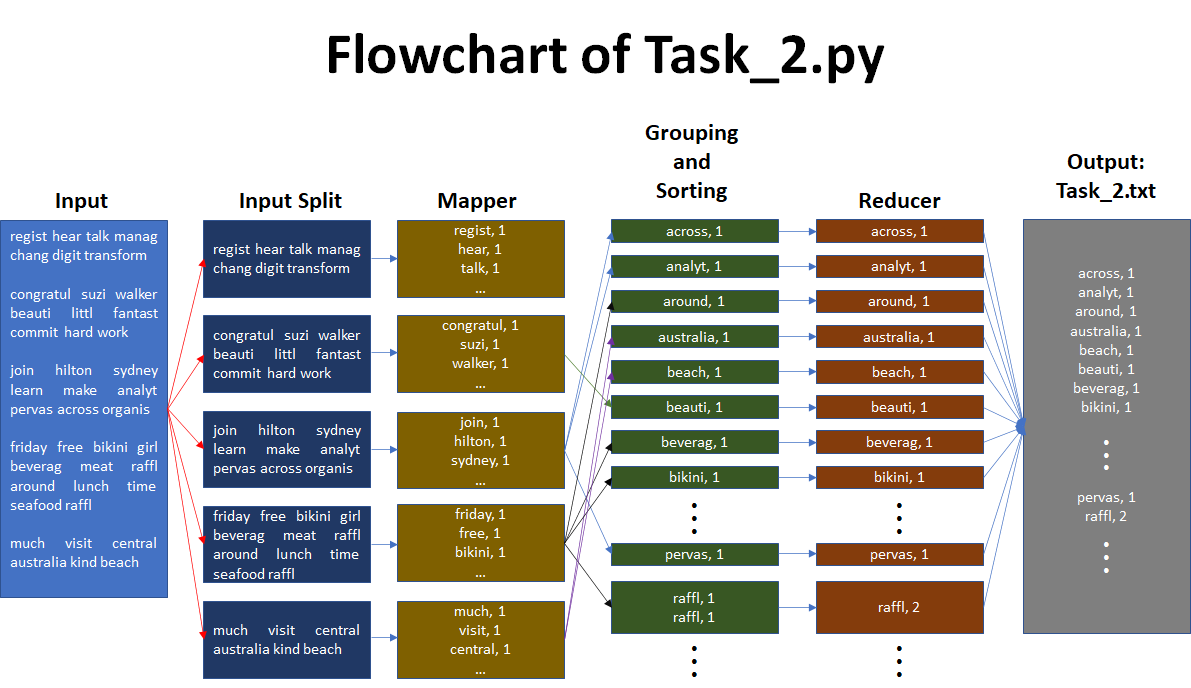

Please note that the input presented in the flowchart above is only a snippet of the entire tweet database, and the splitting is only done as such for ease of illustration.

# Task 3

For this task, we will be creating a MapReduce program that can determine the total number of tweets for a given list of cities in Australia. The following steps will be taken for this task:

 1. Querying the database to ensure that the "locality" field exists. This is because some tweets do not have the "locality" field which contain the city and we do not need them.
 2. Creating a list of the "locality" field where the "country" field is equal to "Australia" and creating a `txt` file called "Cities_Tweets.txt" from that list as the input for the MapReduce program.
 3. Creating a MapReduce program which will use the `txt` file and a list of cities as the input.
 4. Running the MapReduce program which will save the output to a `txt` file.

### Step 1: Querying the database

First, we will look at the cities and countries of the tweets.

In [30]:
# Mapping out the cities
# We put $exists: True to ensure that all the locality field in each tweet exists.
results = col.find({'gnip.profileLocations.address.locality': {'$exists': True}}).limit(50)

# Checking out the cities
for res in results:
    print(res['gnip']['profileLocations'][0]['address']['locality'])
    print(res['gnip']['profileLocations'][0]['address']['country'])
    print('---------------------')

Canberra
Australia
---------------------
Melbourne
Australia
---------------------
Brisbane
Australia
---------------------
Melbourne
Australia
---------------------
Sydney
Australia
---------------------
Sydney
Australia
---------------------
Sydney
Australia
---------------------
Perth
Australia
---------------------
South Melbourne
Australia
---------------------
Brisbane
Australia
---------------------
Perth
Australia
---------------------
Adelaide
Australia
---------------------
Perth
Australia
---------------------
Brisbane
Australia
---------------------
Sydney
Australia
---------------------
Sydney
Australia
---------------------
Sydney
Australia
---------------------
South Melbourne
Australia
---------------------
Sydney
Australia
---------------------
Sydney
Australia
---------------------
Melbourne
United States
---------------------
Sydney
Australia
---------------------
Sydney
Australia
---------------------
Brisbane
Australia
---------------------
Sydney
Australia
-------

It appears that the code works, but if you look closely, not all of the tweets come from Australia. Which is why we will also filter those who are from Australia only.

### Step 2: Creating the input `txt` file

In [31]:
# Setting up the query
# We put $exists: True to ensure that all the locality field in each tweet exists.
results = col.find({'gnip.profileLocations.address.locality': {'$exists': True}})

# Creating a list of the cities where the "country" field is equal to Australia
cities_tweets = []

for res in results:
    if res['gnip']['profileLocations'][0]['address']['country'] == 'Australia':
        city = res['gnip']['profileLocations'][0]['address']['locality']
        cities_tweets.append(city)
        
cities_tweets[:10]

['Canberra',
 'Melbourne',
 'Brisbane',
 'Melbourne',
 'Sydney',
 'Sydney',
 'Sydney',
 'Perth',
 'South Melbourne',
 'Brisbane']

In [32]:
# Saving it as a txt file
with open('Cities_Tweets.txt', 'w') as f:
    for item in cities_tweets:
        f.write("%s\n" % item)

In [33]:
# Checking the txt file
with open('Cities_Tweets.txt', 'r') as f:
    for i, line in enumerate(f):
        if i >= 10:
            break
        print(line.strip())

Canberra
Melbourne
Brisbane
Melbourne
Sydney
Sydney
Sydney
Perth
South Melbourne
Brisbane


### Step 3: Creating the MapReduce program

The code below will create a Python program called **Task_3.py**. The code works as follows:

 1. The `%%writefile Task_3.py` is the code to create the Python program with all the codes in that cell.
 2. `MRJob` class is used to write the MapReduce job.
 3. `configure_args` is used to enable another input file after the MapReduce job, which will be alocated to 'cities'. 
 4. `mapper_init` is used to ensure that the the the second input is turned into a list called 'list_of_cities'.
 5. The `def mapper(self, _, line)` is the first mapper. 
     - The "_" and "line" represents the key and value, where for this mapper, the key will be empty, and the value will be derived from the `txt` file. 
     - If "city" is in the "list_of_cities", the mapper will take each city from the first input and yield a key-value pair of: city, 1
 6. The `def reducer(self, city, counts)` is the first reducer.
     - The "city" and "counts" represents the key and value input, where for this reducer, the input key and input value will be the city and 1 from the mapper.
     - The reducer will then yield each city as key and the sum of the input value as value.
 7. Finally, `if __name__ == '__main__'`, is a standard line telling the program to run the MapReduce job when it is executed.

In [83]:
%%writefile Task_3.py

from mrjob.job import MRJob
import re

class Task_3(MRJob):

    def configure_args(self):
        super(Task_3, self).configure_args()
        self.add_passthru_arg('--cities')

    def mapper_init(self):
        self.list_of_cities = [city.strip().lower() for city in self.options.cities.split(',')]

    def mapper(self, _, line):
        city = line.strip()
        if city.lower() in self.list_of_cities:
            yield (city.lower(), 1)

    def reducer(self, city, counts):
        yield (city, sum(counts))

if __name__ == '__main__':
    Task_3.run()

Overwriting Task_3.py


### Step 4: Running the MapReduce program

Running and saving the output from the MapReduce program.

In [88]:
!python Task_3.py Cities_Tweets.txt --cities="sydney, melbourne, brisbane, south melbourne, bris" > Task_3_Output.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\march\AppData\Local\Temp\Task_3.march.20230403.091002.978964
Running step 1 of 1...
job output is in C:\Users\march\AppData\Local\Temp\Task_3.march.20230403.091002.978964\output
Streaming final output from C:\Users\march\AppData\Local\Temp\Task_3.march.20230403.091002.978964\output...
Removing temp directory C:\Users\march\AppData\Local\Temp\Task_3.march.20230403.091002.978964...


In [91]:
# Checking the result.
n = 10
with open('Task_3_Output.txt', 'r', encoding = 'utf-8') as f:
    for i, line in enumerate(f):
        if i >= n:
            break
        print(line.strip())

"brisbane"	510
"melbourne"	953
"south melbourne"	502
"sydney"	1657


### Pseudocode of the MapReduce program for Task 3

 - Define a class called Task_3 that inherits from MRJob.
     - Define a mapper function that takes a line and strips it.
        - Assign the stripped line to a variable called 'city'.
        - If 'city' is in the second input ('list_of_cities'):
            - Yield a tuple consisting of the lowercase city and the integer 1.
     - Define a reducer function that takes a city and a list of counts.
        - Yield a tuple consisting of the city and the sum of the counts.

### Flowchart of the MapReduce program for Task 3

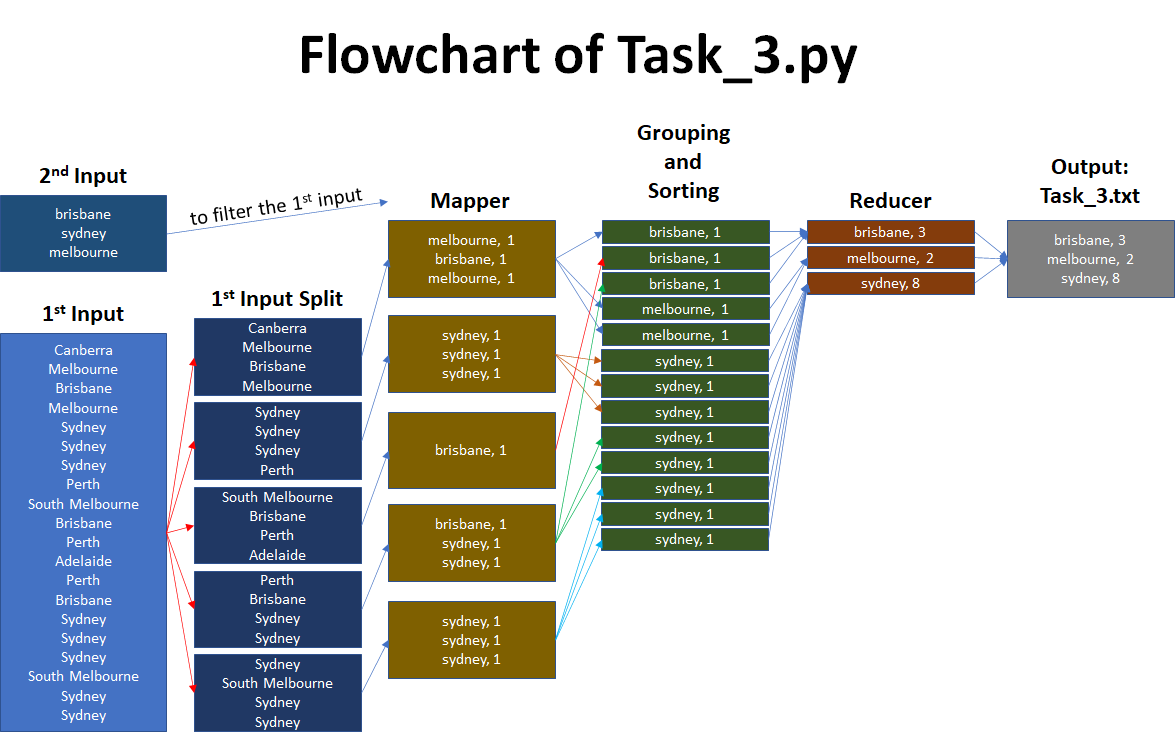

Please note that the input presented in the flowchart above is only a snippet of the entire input file, and the splitting is only done as such for ease of illustration.

# Task 4

For this task, we will be creating a MapReduce program to sort the 10k dataset of tweets based on their tweet ID. The following steps will be taken for this task:

 1. Querying the database and creating a `txt` file based on the 'id' and 'body' fields called "IDs_Tweets.txt".
 2. Creating a MapReduce program which will use the `txt` file as the input.
 3. Running the MapReduce program which will save the output to a `txt` file.
 4. Creating a Merge sort program to be compared to the MapReduce program
 5. Assessing the performance of the MapReduce program and a Merge sort program without MapReduce.

### Step 1: Querying the database and creating the input `txt` file

First, we will save the the 'id' and 'body' field into 'tweet_id' and 'tweet' variables, where:
 - **'tweet_id'** will then remove the prefix "id:twitter.com:" that comes from the original field
 - **'tweet'** will strip any excess whitespaces and will also replace the line break with an ordinary whitespace. Why? If this is not performed, the program will read each individual line as a key-value pair.

Finally, we will combine the 'tweet_id' and 'tweet' into a `CSV` format and create a `txt` file with the 'utf-8' encoding to preserve all the tweets, such as emojis.

In [37]:
# Setting up the query
results = col.find({})

# Saving it as a txt file
# We use encoding = 'utf-8' to make sure that all characters such as emoji or non-english characters are saved

with open('IDs_Tweets.txt', 'w', encoding = 'utf-8') as f:
    for res in results:
        tweet_id = res['actor']['id']
        tweet_id = re.sub(r'id:twitter.com:', '', tweet_id) # Removing the prefix to get the IDs
        tweet = res['body'].strip()
        tweet = tweet.replace('\n', ' ')
        f.write(tweet_id + ',' + tweet + '\n')

Checking the first 5 rows of the `txt` file.

In [38]:
with open('IDs_Tweets.txt', 'r', encoding = 'utf-8') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line)

18064228,Register for #Convergence2016 to hear@ChelleMelbourne talk about how to manage change through digital transformation https://t.co/7pxwwDeaXm

188921458,CONGRATULATIONS Suzie Walker on both your beautiful little man and your FANTASTIC commitment and hard work. You... https://t.co/m4QLVq0BTr

126525057,Join us @ the Hilton Sydney 2 learn how 2 make analytics pervasive across yr organisation https://t.co/xGO7cZy9yU https://t.co/otxAeyMHMV

97578801,Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67pct, Winds NNW @ 0.0 km/h, Rain Today  0 mm, 1014.3 hpa &amp; Steady. #vicweather

3266593548,So much to see and do when you Visit Central Australia "We have our own kind of beaches in the #RedCentreNT! The... https://t.co/eRyP7eTk9X



### Step 2: Creating the MapReduce program

The code below will create a Python program called **Task_4.py**. The code works as follows:

 1. The `%%writefile Task_4.py` is the code to create the Python program with all the codes in that cell.
 2. `MRJob` and `MRStep` classes are used to write the MapReduce jobs.
 3. The `def mapper(self, _, line)` is the first mapper. 
     - The "_" and "line" represents the key and value, where for this mapper, the key will be empty, and the value will be derived from the `txt` file. 
     - The mapper will then unpack the value into the variable 'items'.
     - The mapper will take each of the unpacked value and yield a key-value pair of: Twitter ID, Tweet
 4. The `def reducer(self, tweet_id, tweets)` is the first reducer.
     - The "tweet_id" and "tweets" represents the key and value input, where for this reducer, the input key and input value will be the Twitter ID and Tweet from the mapper.
     - The input for the value from tweets will be a list of the Tweets for that Twitter ID, which is why we are iterating it. If this is not done, the output of the reducer will not be as expected. For instance,
         - We are expecting the output to be:
             - 123, "First Tweet"
             - 123, "Second Tweet"
         - But, if we don't iterate the list, it will be:
             - 123, \["First Tweet", "Second Tweet"\]
     - Finally, it will give a key-value pair of the tweet_id and the tweets.
 5. The `def mapper_sort(self, tweet_id, tweets)` is the second mapper.
     - Unlike the first mapper where the key parameter is "_", for the second mapper, we will be using the key from the first reducer as the input which is why we put "tweet_id" as the key paramater to indicate that there will be an input.
     - This mapper will yield a new key-value pair which is "sorter", (tweet_id, tweets). What this mean is, all the keys will be equal to "sorter" (please note that this word is just a placeholder), and the value will be equal to (tweet_id, tweets). We are doing this in order to have a value that we can sort later.
 6. The `def reducer_sort(self, _, tweet_pairs)` is the second reducer.
     - Similar to the first mapper, this second reducer uses "_" as the key parameter. This is to indicate that it will not take the input key from the second mapper, and will only take the input value.
     - The reducer will then unpack the sorted input value into the variable tweet_id and tweets.
     - The reducer will then yield the new sorted key-value pair, where the key is tweet_id and value is the tweets.
 7. The `def steps(self)` is a function that determine the jobs' order.
 8. Finally, `if __name__ == '__main__'`, is a standard line telling the program to run the MapReduce job when it is executed.

In [39]:
%%writefile Task_4.py

from mrjob.job import MRJob
from mrjob.step import MRStep

class Task_4(MRJob):

    def mapper(self, _, line):
        items = line.split(',', 1)
        yield int(items[0]), items[1].strip()

    def reducer(self, tweet_id, tweets):
        for tweet in tweets:
            yield tweet_id, tweet

    def mapper_sort(self, tweet_id, tweets):
        yield ("sorter", (tweet_id, tweets))

    def reducer_sort(self, _, tweet_pairs):
        for tweet_id, tweets in sorted(tweet_pairs, reverse = False):
            yield (tweet_id, tweets)

    def steps(self):
        return [
            MRStep(mapper=self.mapper, reducer=self.reducer),
            MRStep(mapper=self.mapper_sort, reducer=self.reducer_sort)
        ]
    
if __name__ == '__main__':
    Task_4.run()

Writing Task_4.py


### Step 4: Running the MapReduce program

Running and saving the output from the MapReduce program.

In [40]:
!python Task_4.py IDs_Tweets.txt > Task_4_Output.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071047.696929
Running step 1 of 2...
Running step 2 of 2...
job output is in C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071047.696929\output
Streaming final output from C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071047.696929\output...
Removing temp directory C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071047.696929...


In [92]:
# Checking the first 5 rows of the output.
with open('Task_4_Output.txt', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line)

11237	"@PetraMasekArt check out Enabled by design, I think you would have loved this ;) (miss you xx) https:\/\/t.co\/UGbjcBShEX \/ @inclusive_tech"

56733	"RT @Telerik: .@johnbristowe is rocking it at #Build2016 #NativeScript &amp; #VisualStudio @Code together at last! https:\/\/t.co\/1aP4CgXxbt"

56733	"RT @WWE: Have we seen the formation of a new alliance between @RealSummerWWE @LanaWWE @EmmaWWE @NaomiWWE and @TaminaSnuka? https:\/\/t.co\/SdD\u2026"

99843	"Trust me, cold brew and tonic on ice is not too shabby."

640903	"@_cz hah, no. I just see people on Twitter getting very upset about things that (in the long run) don\u2019t matter. I guess that answers itself."



As can be observed, the output uses different encoding because it is run through MRJob. However, the tweets are still being saved appropriately.

### Pseudocode of the MapReduce program for Task 4

 - Define a class called Task_4 that inherits from MRJob.
     - Define a mapper function that takes a line and splits it by comma, with a maximum of 1 split.
         - Assign the first item in the resulting list to a variable called 'tweet_id'.
         - Assign the second item in the resulting list to a variable called 'tweets'.
         - Yield a tuple consisting of the integer tweet_id and the stripped tweets.
     - Define a reducer function that takes a tweet_id and a list of tweets.
         - For each tweet in the list of tweets, yield a tuple consisting of the tweet_id and the tweet.
     - Define a mapper_sort function that takes a tweet_id and a tweets.
         - Yield a tuple consisting of the string 'sorter' and a tuple consisting of the tweet_id and the tweets.
     - Define a reducer_sort function that takes a key and a list of tuples containing tweet_ids and tweets.
         - For each tuple in the sorted list of tuples, with the tuples sorted in ascending order by tweet_id:
         - Yield a tuple consisting of the tweet_id and the tweets.
     - Define a function called steps that returns a list of MRStep objects, where each MRStep object has a mapper and a reducer assigned to it.
         - The first MRStep object uses the mapper and reducer functions defined earlier.
         - The second MRStep object uses the mapper_sort and reducer_sort functions defined earlier.

### Flowchart of the MapReduce program for Task 4

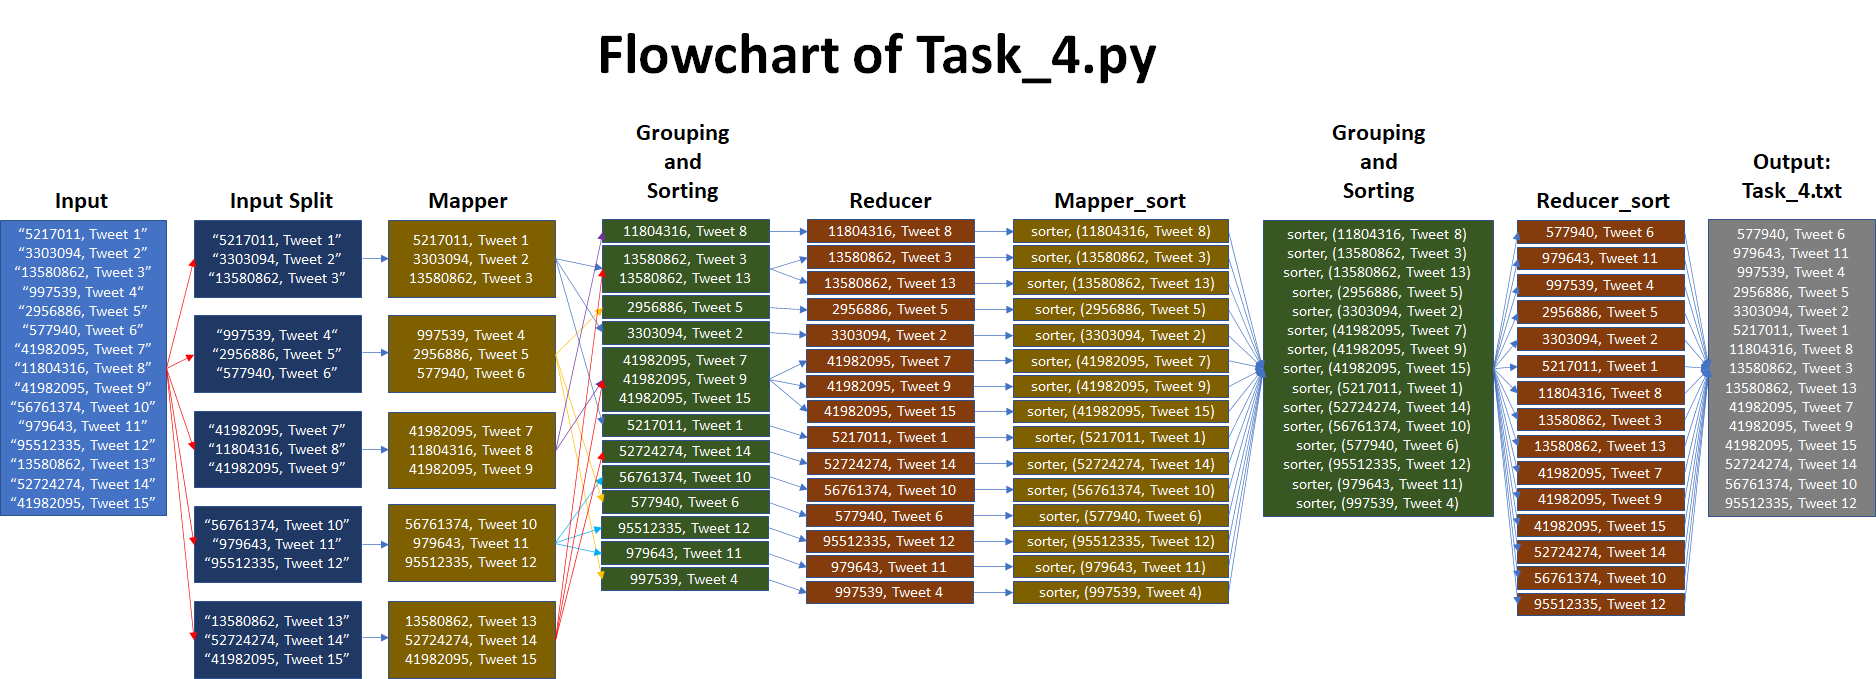

Please note that the input used in the flowchart above is for the sake of example only. In addition, the input at first are strings with CSV format, i.e., "5217011, Tweet 1", and only after it enters the mapper function that it become key-value pairs.

### Step 4: Creating the Merge sort program

Before we are able to assess the performance of the MapReduce program against a Merge sort program without MapReduce, we need to create a Merge sort program.

Basically, the two functions below are:
 - `merge_sort_tweets` takes a list of lists containing the key-value pair, split them in half, and sort them based on their Twitter ID.
 - `merge` is used by the previous function to merge two sorted lists into a single list.

In [42]:
def merge_sort_tweets(tweets):
    if len(tweets) <= 1:
        return tweets

    mid = len(tweets) // 2
    left_half = tweets[:mid]
    right_half = tweets[mid:]

    left_half = merge_sort_tweets(left_half)
    right_half = merge_sort_tweets(right_half)

    return merge(left_half, right_half)

def merge(left_half, right_half):
    merged_list = []
    i = 0
    j = 0

    while i < len(left_half) and j < len(right_half):
        if int(left_half[i][0]) < int(right_half[j][0]):
            merged_list.append(left_half[i])
            i += 1
        else:
            merged_list.append(right_half[j])
            j += 1

    while i < len(left_half):
        merged_list.append(left_half[i])
        i += 1

    while j < len(right_half):
        merged_list.append(right_half[j])
        j += 1

    return merged_list

Creating a list which will be used as the input for the `merge_sort_tweets` program and saving it as a `txt` file.

In [43]:
# Setting up the query
results = col.find({})

# Creating the list
merge_sort_list = []

for res in results:
    tweet_id = res['actor']['id']
    tweet_id = re.sub(r'id:twitter.com:', '', tweet_id) # Removing the prefixes to get the IDs
    tweet = res['body'].strip()
    tweet = tweet.replace('\n', ' ')
    merge_sort_list.append((tweet_id, tweet))

merge_sort_list[:5]

[('18064228',
  'Register for #Convergence2016 to hear@ChelleMelbourne talk about how to manage change through digital transformation https://t.co/7pxwwDeaXm'),
 ('188921458',
  'CONGRATULATIONS Suzie Walker on both your beautiful little man and your FANTASTIC commitment and hard work. You... https://t.co/m4QLVq0BTr'),
 ('126525057',
  'Join us @ the Hilton Sydney 2 learn how 2 make analytics pervasive across yr organisation https://t.co/xGO7cZy9yU https://t.co/otxAeyMHMV'),
 ('97578801',
  'Wantirna, VIC, AU 11:00 AM Temp 19.8°C, RH 67pct, Winds NNW @ 0.0 km/h, Rain Today  0 mm, 1014.3 hpa &amp; Steady. #vicweather'),
 ('3266593548',
  'So much to see and do when you Visit Central Australia "We have our own kind of beaches in the #RedCentreNT! The... https://t.co/eRyP7eTk9X')]

Running and saving the output from the `merge_sort_tweets` program.

In [44]:
# Saving it as a txt file
# We use encoding = 'utf-8' to make sure that all characters such as emoji or non-english characters are saved

with open('Task_4_Output_MergeSort.txt', 'w', encoding = 'utf-8') as f:
    pairs = merge_sort_tweets(merge_sort_list)
    for p in pairs:
        f.write(p[0] + ' ' + p[1] + '\n')

In [45]:
# Checking the first 5 rows of the output
with open('Task_4_Output_MergeSort.txt', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line)

11237 @PetraMasekArt check out Enabled by design, I think you would have loved this ;) (miss you xx) https://t.co/UGbjcBShEX / @inclusive_tech

56733 RT @Telerik: .@johnbristowe is rocking it at #Build2016 #NativeScript &amp; #VisualStudio @Code together at last! https://t.co/1aP4CgXxbt

56733 RT @WWE: Have we seen the formation of a new alliance between @RealSummerWWE @LanaWWE @EmmaWWE @NaomiWWE and @TaminaSnuka? https://t.co/SdD…

99843 Trust me, cold brew and tonic on ice is not too shabby.

640903 @_cz hah, no. I just see people on Twitter getting very upset about things that (in the long run) don’t matter. I guess that answers itself.



### Step 5: Assessing the performance of the MapReduce program

To assess the performance of a program, we can use `%%time` to check how long it takes for the program to run. `%%time` will give out two results:
 1. CPU time: is the amount of time the CPU spent executing the code, or in other word the process time.
 2. Wall time: is the actual amount of time that has elapsed from the start of the program until its end. 

Using the normal input file.

In [46]:
%%time

with open('Task_4_Output_MergeSort.txt', 'w', encoding = 'utf-8') as f:
    pairs = merge_sort_tweets(merge_sort_list)
    for p in pairs:
        f.write(p[0] + ' ' + p[1] + '\n')

CPU times: total: 46.9 ms
Wall time: 184 ms


In [47]:
%%time

!python Task_4.py IDs_Tweets.txt > Task_4_Output.txt

CPU times: total: 0 ns
Wall time: 3.32 s


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071052.763441
Running step 1 of 2...
Running step 2 of 2...
job output is in C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071052.763441\output
Streaming final output from C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071052.763441\output...
Removing temp directory C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071052.763441...


Using the input file times 10, i.e., 100,000 tweets

In [48]:
%%time

# Increasing the number of tweet pairs by 10 times
with open('Task_4_Output_MergeSort_10x.txt', 'w', encoding = 'utf-8') as f:
    pairs = merge_sort_tweets(merge_sort_list*10)
    for p in pairs:
        f.write(p[0] + ' ' + p[1] + '\n')

CPU times: total: 672 ms
Wall time: 1.95 s


In [49]:
# Setting up the query
results = col.find({})

# Saving it as a txt file
# We use encoding = 'utf-8' to make sure that all characters such as emoji or non-english characters are saved

with open('IDs_Tweets_10x.txt', 'w', encoding = 'utf-8') as f:
    for res in results:
        tweet_id = res['actor']['id']
        tweet_id = re.sub(r'id:twitter.com:', '', tweet_id) # Removing the prefix to get the IDs
        tweet = res['body'].strip()
        tweet = tweet.replace('\n', ' ')
        for i in range(10):
            f.write(tweet_id + ',' + tweet + '\n')

In [50]:
%%time

!python Task_4.py IDs_Tweets_10x.txt > Task_4_Output_10x.txt

CPU times: total: 0 ns
Wall time: 7.81 s


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071059.993978
Running step 1 of 2...
Running step 2 of 2...
job output is in C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071059.993978\output
Streaming final output from C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071059.993978\output...
Removing temp directory C:\Users\march\AppData\Local\Temp\Task_4.march.20230403.071059.993978...


**Conclusion**  

From the result above, it can be observed that the processing time of the MapReduce program is significantly lower at $\approx$ 0 ns (please note that 1 ms = 1,000,000 ns). Please find the table summarising the performance of both programs:  

| **Program** | 10,000 Tweets | 100,000 Tweets |
| ----------- | ------------- | -------------- |
| MapReduce   | CPU Time: $\approx$ 0ns <br> Wall Time: 2.5s to 6s| CPU Time: $\approx$ 0ns <br> Wall Time: 5.5s to 7s|
| Merge Sort  | CPU Time: 46ms to 100ms <br> Wall Time: 130ms to 180ms| CPU Time: 700ms to 1s <br> Wall Time: 1.5s to 2s|

As can be observed the processing time for the MapReduce program is approximately 0ns for a 10,000 tweets database and a 100,000 tweets database, it practically remain the same. On the other hand, a ten times increase in the database size has increased the processing time of the Merge Sort program by more than 10 times. We can imagine that processing billions of tweets will significantly take even longer if we use Merge Sort program without MapReduce.  

This is because a MapReduce program is designed to distribute the computation across multiple machines (but, since we only have one machine, it will be spread across multiple cores), allowing for parallel processing. Each mapper and reducer function is executed on a separate piece of data in parallel, which can significantly speed up the processing time. However, the Merge Sort program is likely running on a single core, which limits its ability to take advantage of parallel processing. As a result, it has to perform all of the processing serially, which can take longer overall.

It can also be observed that the Wall Time of the MapReduce program is longer than the Merge Sort program. However, we do not need to worry as this is not because of the processing time (obviously), but because there is an overhead involved in setting up the MapReduce framework. On the other hand, the Merge Sort program does not have these overhead and can perform the sorting operation directly on the local machine, which can result in a lower wall time.

# Task 5

For this task, we will be creating a DASK program to implement the TF-IDF algorithm for each keyword extracted from the text of the tweet in a large Tweets dataset. The output will include the top N keywords with their corresponding TF-IDF scores, and the value of N will be configurable.

The DASK program can be explained as follows:  


**Step 1: Creating the DASK dataframe**
 - Combining all the cleaned tweets into one single string which will be the input.
 - Creating the `TfidfVectorizer` object and call it "vectorizer". This will be used to transform the text data into a matrix of TF-IDF scores.
 - Using the `TfidfVectorizer` object, we apply the `fit_transform` method to the input, which converts the text data into a matrix of TF-IDF scores (since there's only 1 document, it will only be an N x 1 matrix where N is the total number of unique words).
 - Extracting the feature names (or the keywords) to be used as the column names later.
 - Creating a Pandas dataframe using the matrix as the value and the feature names as the column names.
 - Creating a DASK dataframe from the previously created Pandas dataframe. This will allow for distributed computation on the dataset.  
 
Please note that `npartitions` is set to 1 because with our current dataset, we don't really need to utilise the parallel processing as a single core can handle it. If we try to increase the number of partitions, it will take a longer time for DASK to perform the computation when compared to Pandas. This is because DASK need to set up the partitions prior to computing while at the same time Pandas will have finished its computation.
 
 
**Step 2: Creating the DASK program**
 - Creating the line prompt where we can configure the top N keywords we would like to see.
 - Computing the DASK dataframe into a Pandas dataframe using the `compute()` method.
 - Sorting the result in a descending order, and only showing the first N rows of the data, where N comes from our configuration.

### Step 1: Creating the DASK dataframe

In [51]:
# Setting up the combined tweets for the input
    # Opening the file in read mode
with open('Cleaned_Tweets.txt', 'r') as file:
    # Reading all the lines from the file and combine them into a single string
    combined_tweets = ''.join(file.readlines())
    combined_tweets = combined_tweets.replace('\n', '')


# Creating the TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Converting the list of cleaned tweets to a TF-IDF matrix
tfidf = vectorizer.fit_transform([combined_tweets])

# Getting the feature names (i.e., the keywords)
feature_names = vectorizer.get_feature_names_out()

# Creating a Pandas DataFrame from the TF-IDF matrix
pdf = pd.DataFrame(tfidf.toarray(), columns = feature_names).transpose()

# Creating a DASK DataFrame from the Pandas DataFrame
df = dd.from_pandas(pdf, npartitions = 1)

### Step 2: Creating the DASK program

In [94]:
# Get the input for N and the tweet (document) number
n = int(input("Please enter how many top keywords to show: "))

# Get the top N keywords with their TF-IDF scores
df_selected = df.compute()
df_selected.columns = ['TF-IDF']
top_n_keywords = df_selected.sort_values(by = ['TF-IDF'], ascending=False).head(n)

# Print the top N keywords with their TF-IDF scores
print(f'\nThe top {n} keywords for all the tweets are:')
top_n_keywords

Please enter how many top keywords to show: 10

The top 10 keywords for all the tweets are:


,TF-IDF
threat,0.203659
like,0.198346
activist,0.193919
union,0.177980
time,0.173553
need,0.170896
strike,0.135478
make,0.127508
peopl,0.127508
clinton,0.123081


As can be observed, the top N keywords have been printed successfully.

In [97]:
# Creating the txt file
top_n_keywords.to_csv('Task_5_Output.txt', header=None, sep=' ')

### Interpretation of the output

The result which can be seen in the previous section is the importance of the word in that document. Since we only have one document, the TF-IDF score will be equal to the normalised TF values, because the IDF values for all of the keywords are equal to:  

$\log{\frac{(1 + n)}{1 + x_t}} + 1 = \log{\frac{2}{2}} + 1 = 1$, where $n = $ total number of documents, and $x_t = $ total number of documents where the keywords ($t$) appear.  

From the result, it can be seen that the words "threat", "like", "activist", "union", and "time" are the top 5 keywords from all of the tweets. Since we are only processing a single document, this means that these words are the words that have the most frequency, which is the same as the output from **Task 2**.

A breakdown of the calculation of the TF-IDF using the scikit-learn package can be observed below:

In [53]:
# Converting the list of cleaned tweets to a TF-IDF matrix
sample_text = "hello world how are you world"
sample_tfidf = vectorizer.fit_transform([sample_text])

# Getting the feature names (i.e., the keywords)
sample_feature_names = vectorizer.get_feature_names_out()

# Creating a Pandas DataFrame from the TF-IDF matrix
sample_pdf = pd.DataFrame(sample_tfidf.toarray(), columns = sample_feature_names).transpose()

# Creating a DASK DataFrame from the Pandas DataFrame
sample_df = dd.from_pandas(sample_pdf, npartitions = 1)
sample_df.columns = ['TF-IDF']

# Showing all the keywords and their respective TF-IDF scores
sample_df.compute().sort_values(by = ['TF-IDF'], ascending = False)

,TF-IDF
world,0.707107
are,0.353553
hello,0.353553
how,0.353553
you,0.353553


In [54]:
# Calculating the TF-IDF score of the word "world"
sample_word_list = ['world', 'are', 'hello', 'how', 'you']

no_doc_total = 1 # number of total documents
no_doc_appears = 1 # number of documents the word appears in

print('TF-IDF scores of the sample text:')
for word in sample_word_list:
    tf_score = sample_text.count(word) # Number of occurence of the word
    idf_score = log((1 + no_doc_total)/(1 + no_doc_appears)) + 1
    tfidf_score = tf_score*idf_score
    print(f'{word}: {tfidf_score}')

TF-IDF scores of the sample text:
world: 2.0
are: 1.0
hello: 1.0
how: 1.0
you: 1.0


In [55]:
# Normalising the TF-IDF score to avoid large documents dominating the others
# This is what is being used by scikit-learn

base_score = [2, 1, 1, 1, 1]

print('Normalised TF-IDF scores of the sample text:')
for s, word in enumerate(sample_word_list):
    
    normalised_score = base_score[s] / sqrt(base_score[0]**2 + base_score[1]**2 +
                                            base_score[2]**2 + base_score[3]**2 +
                                            base_score[4]**2)
    print(f'{word}: {normalised_score}')

Normalised TF-IDF scores of the sample text:
world: 0.7071067811865475
are: 0.35355339059327373
hello: 0.35355339059327373
how: 0.35355339059327373
you: 0.35355339059327373


### Limitation of the approach

Using the current approach, there are several limitations:

1. By combining all 10,000 tweets into a single tweet, that is combining 10,000 documents into a single document, we lose the document-level information that could be important. For instance, with the current approach, the top keywords will only be the most frequent or recurring words. In addition, it won't be able to capture rare words that may be important because of its low frequency in the corpus.
    - Future improvements: We could assess each tweet separately, and extract the top N keywords from each tweet. Then, we could analyse the keywords extracted for further analysis. 
2. The `TfidfVectorizer` is a bag-of-word model, which means that it does not capture the sequence or context of words. As a result, it could lead to the loss of important information. For instance, the compound words like "ice cream" is a dessert, but `TfidVectorizer` will read it as "ice" and "cream" which will give different meaning. 
    - Future improvements: We could consider using other models, such as the n-gram model or the Word2Vec model, which capture the context of words.